# Offer amount prediction EY with classification

In [ ]:
!pip install ipython-sql

In [ ]:
#!pip install -U numpy

In [ ]:
#!python --version

In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.0.


In [2]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [3]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
query="""
SELECT * FROM ml_prep.gauthier_offer_amount_prediction_dataset_wy WHERE channel_source IS NOT NULL ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


auto_id                              event_id  offer_id origin dest  \
0  12539910  bc254534-4664-43d6-b4cd-d1365df33630   9775062    MCT  MXP   
1  11761659  6bd4e49f-e82e-403a-8481-b7128a1ac64b   9186420    CGK  MCT   
2  11817739  74f488d1-a825-404a-952a-c7b980c65c37   9157057    MCT  KWI   

  carrier     pnr  base_offer_amount currency  customer_id  ...  \
0      WY  SBDDWZ             496.13      EUR      6933351  ...   
1      WY  VRHDMH             260.00      USD      6527870  ...   
2      WY  RTSEEN             165.00      USD      6507878  ...   

  offer_load_count   first_email_sent_time    last_email_sent_time  \
0                3 2019-08-23 06:05:26.570 2019-08-26 06:05:20.561   
1                4 2019-06-25 06:04:03.383 2019-06-30 06:06:14.370   
2                1 2019-06-26 06:05:56.183 2019-06-26 06:05:56.183   

   email_sent_count first_email_opened_time  last_email_opened_time  \
0                 3     2019-08-23 07:56:22     2019-08-30 17:45:26   
1                12                     NaT                     NaT   
2                 2                     NaT                     NaT   

   email_opened_count  first_email_clicked_time  last_email_clicked_time  \
0                  14                       NaT                      NaT   
1                   0       2019-06-28 04:39:30      2019-06-29 10:33:02   
2                   0                       NaT                      NaT   

   email_clicked_count  
0                    0  
1                    4  
2                    0  

[3 rows x 67 columns]

In [5]:
df.info()qc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21511 entries, 0 to 21510
Data columns (total 67 columns):
auto_id                                21511 non-null int64
event_id                               21511 non-null object
offer_id                               21511 non-null int64
origin                                 21511 non-null object
dest                                   21511 non-null object
carrier                                21511 non-null object
pnr                                    21511 non-null object
base_offer_amount                      21511 non-null float64
currency                               21511 non-null object
customer_id                            21511 non-null int64
locale                                 21511 non-null object
departure_time                         21511 non-null datetime64[ns]
departure_time_server                  21511 non-null datetime64[ns]
duration                               21511 non-null int64
fare_class              

# Feature Engineering

In [6]:
#drop non relevant fields
df = df.drop(['request_id',  'pnr', 'offer_row_number','status',
                'offer_expiration_cutoff_local'       ,
                'offer_expiration_cutoff_server' ,     
                'offer_expiration_minutes'       ,     
                'offer_modification_cutoff_hours'   ,  
                'offer_modification_cutoff_local'   ,  
                'offer_modification_cutoff_server'    ,
                'on_hold'                  ,           
              'is_recent_offer','is_orphaned','customer_id','has_errors'  ], axis=1)



In [7]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_time']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_time']).apply(lambda x: x.month)
df['submission_day_of_week']= pd.to_datetime(df['submission_date']).apply(lambda x: x.dayofweek)
df['submission_hour']= pd.to_datetime(df['submission_date']).apply(lambda x: x.hour)
df['submission_month']= pd.to_datetime(df['submission_date']).apply(lambda x: x.month)
df['submission_year']= pd.to_datetime(df['submission_date']).apply(lambda x: x.year)
df['origin_destination'] = df['origin']+ df['dest']
df["days_before_departure"] =(pd.to_datetime(df["departure_time"])-pd.to_datetime(df["submission_date"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["submission_date"].dt.tz_localize(None)) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_sent"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_sent"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_opened"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_opened"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_time"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["submission_date"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)



In [8]:
df.head(3)

auto_id                              event_id  offer_id origin dest  \
0  12539910  bc254534-4664-43d6-b4cd-d1365df33630   9775062    MCT  MXP   
1  11761659  6bd4e49f-e82e-403a-8481-b7128a1ac64b   9186420    CGK  MCT   
2  11817739  74f488d1-a825-404a-952a-c7b980c65c37   9157057    MCT  KWI   

  carrier  base_offer_amount currency locale      departure_time  ...  \
0      WY             496.13      EUR     en 2019-08-30 14:40:00  ...   
1      WY             260.00      USD     en 2019-07-01 14:50:00  ...   
2      WY             165.00      USD     en 2019-07-03 14:10:00  ...   

  last_email_opened_days_before_departure  days_since_first_email_opened  \
0                                      -1                              6   
1                                       0                              0   
2                                       0                              0   

  days_since_last_email_opened  first_email_clicked_days_before_departure  \
0                           -2                                          0   
1                            0                                          3   
2                            0                                          0   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         0                               0   
1                                         2                               1   
2                                         0                               0   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                   2   
1                              0                                   5   
2                              0                                   0   

   days_between_first_last_email_opened days_between_first_last_email_clicked  
0                                     7                                     0  
1                                     0                                     1  
2                                     0                                     0  

[3 rows x 78 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21511 entries, 0 to 21510
Data columns (total 78 columns):
auto_id                                      21511 non-null int64
event_id                                     21511 non-null object
offer_id                                     21511 non-null int64
origin                                       21511 non-null object
dest                                         21511 non-null object
carrier                                      21511 non-null object
base_offer_amount                            21511 non-null float64
currency                                     21511 non-null object
locale                                       21511 non-null object
departure_time                               21511 non-null datetime64[ns]
departure_time_server                        21511 non-null datetime64[ns]
duration                                     21511 non-null int64
fare_class                                   21511 non-null object
flight

# Feature Encoding

In [10]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [11]:
# label-encode categories
df= label_encode_categorical(df,['upgrade_type','fare_class','origin','dest','origin_destination','locale','point_of_sale','carrier','channel_source','equipment'])

label encoding upgrade_type ...
label encoding fare_class ...
label encoding origin ...
label encoding dest ...
label encoding origin_destination ...
label encoding locale ...
label encoding point_of_sale ...
label encoding carrier ...
label encoding channel_source ...
label encoding equipment ...


# Label encoding

In [12]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['offer_strength'])
df['offer_strength_encoded'] = label_encoder.transform(df['offer_strength'])

In [13]:
df["slider_min_usd"] = df["slider_min_usd"].fillna(0)
df["slider_max_usd"] = df["slider_max_usd"].fillna(0)
df["slider_starting_usd"] = df["slider_starting_usd"].fillna(0)

In [14]:
label_encoder.classes_

array(['HIGH', 'LOW', 'MEDIUM'], dtype=object)

In [15]:
df.head(3)

auto_id                              event_id  offer_id origin dest  \
0  12539910  bc254534-4664-43d6-b4cd-d1365df33630   9775062    MCT  MXP   
1  11761659  6bd4e49f-e82e-403a-8481-b7128a1ac64b   9186420    CGK  MCT   
2  11817739  74f488d1-a825-404a-952a-c7b980c65c37   9157057    MCT  KWI   

  carrier  base_offer_amount currency locale      departure_time  ...  \
0      WY             496.13      EUR     en 2019-08-30 14:40:00  ...   
1      WY             260.00      USD     en 2019-07-01 14:50:00  ...   
2      WY             165.00      USD     en 2019-07-03 14:10:00  ...   

  fare_class_encoded  origin_encoded dest_encoded  origin_destination_encoded  \
0                  9              41           47                          88   
1                  5              11           41                          11   
2                  7              41           35                          77   

   locale_encoded  point_of_sale_encoded  carrier_encoded  \
0               1                      5                0   
1               1                      7                0   
2               1                      7                0   

   channel_source_encoded  equipment_encoded offer_strength_encoded  
0                      11                  0                      2  
1                       0                  2                      1  
2                      11                  4                      1  

[3 rows x 89 columns]

In [16]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'submission_hour',
                       'submission_day_of_week',
                       'submission_month',
                       'submission_year',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'dest_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       #'distance', 
                       # the rest
                       'channel_source_encoded',
                       'locale_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       'fare_class_encoded',
                       'upgrade_type_encoded',
                       # partner
                       # since we just have EY ¯\_(ツ)_/¯
                       #'carrier_encoded',
                       # slider
                        'slider_max_usd',        
                        'slider_min_usd',        
                        'slider_starting_usd',  
                        'starting_slider_strength_percentage',
                        'slider_min_max_ratio',
                        'slider_range_usd',
                       # offer loads
                        'first_offer_load_days_before_departure',
                        'days_since_first_offer_load',
                        'offer_load_count',
                        # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                        'offer_strength_encoded',
                      ]

df = df[columns_for_training]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21511 entries, 0 to 21510
Data columns (total 47 columns):
departure_hour                               21511 non-null int64
departure_day_of_week                        21511 non-null int64
departure_month                              21511 non-null int64
submission_hour                              21511 non-null int64
submission_day_of_week                       21511 non-null int64
submission_month                             21511 non-null int64
submission_year                              21511 non-null int64
days_before_departure                        21511 non-null int64
origin_encoded                               21511 non-null int64
dest_encoded                                 21511 non-null int64
origin_destination_encoded                   21511 non-null int64
duration                                     21511 non-null int64
channel_source_encoded                       21511 non-null int64
locale_encoded                   

In [18]:
df.head(4)

departure_hour  departure_day_of_week  departure_month  submission_hour  \
0              14                      4                8               12   
1              14                      0                7               10   
2              14                      2                7                6   
3               1                      4                7                7   

   submission_day_of_week  submission_month  submission_year  \
0                       3                 8             2019   
1                       5                 6             2019   
2                       2                 6             2019   
3                       6                 6             2019   

   days_before_departure  origin_encoded  dest_encoded  ...  \
0                      1              41            47  ...   
1                      2              11            41  ...   
2                      7              41            35  ...   
3                      4              41            22  ...   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         0                               0   
1                                         2                               1   
2                                         0                               0   
3                                         4                               2   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                   2   
1                              0                                   5   
2                              0                                   0   
3                              0                                  47   

   days_between_first_last_email_opened  \
0                                     7   
1                                     0   
2                                     0   
3                                    47   

   days_between_first_last_email_clicked  email_sent_count  \
0                                      0                 3   
1                                      1                12   
2                                      0                 2   
3                                      2                 8   

   email_opened_count  email_clicked_count  offer_strength_encoded  
0                  14                    0                       2  
1                   0                    4                       1  
2                   0                    0                       1  
3                  17                    4                       1  

[4 rows x 47 columns]

# Model Training & Evaluation

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [20]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False):
    # X-validation
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest =  OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
    X = df_to_train.drop("offer_strength_encoded", axis=1)
    y_raw = df_to_train["offer_strength_encoded"]
    
    y = label_binarize(y_raw, classes=[0, 1, 2])

    n_classes = y.shape[1]
    
    if split_on_time:
        X_train = X[X["submission_year"] == 2019 ].drop("submission_year", axis=1)
        y_train = y[X["submission_year"] == 2019]
        X_test = X[X["submission_year"] == 2020].drop("submission_year", axis=1)
        y_test = y[X["submission_year"] == 2020]
        pass
    else:
        X = X.drop("submission_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics

    roc_auc = dict()
    
    colors = ['red', 'blue', 'green']
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        fpr, tpr, _ = metrics.roc_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('ROC')
        plt.plot([0, 1], [0,1], 'k--')
        roc_auc_for_one_class=metrics.auc(fpr, tpr)
        roc_auc[i] = roc_auc_for_one_class
        plt.plot(fpr, tpr,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_auc_for_one_class))
        plt.legend(loc="center right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    roc_auc = metrics.roc_auc_score(y_test,y_test_proba,multi_class="ovr")
    
    print('global roc_auc',roc_auc)
    
    
    plt.figure(figsize=(16,9))
    for i,color in zip(range(n_classes),colors):
        precisions, recalls, thresholds = metrics.precision_recall_curve(y_test[:, i], y_test_proba[:, i])
        plt.title('Precision-Recall')
        roc_pr_for_one_class=metrics.auc(recalls, precisions)
        plt.plot(recalls, precisions,marker='.',color=color, label='{0} (AUC = {1:0.2f})'.format(label_encoder.classes_[i], roc_pr_for_one_class))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="center right")
        # proportion of positive examples
        #no_skill = len(y[y==1]) / len(y)
        #plt.plot([0, 1], [no_skill, no_skill], linestyle='--')

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    for i in range(n_classes):
        print('#### CLASS',label_encoder.classes_[i],'####')
        print('precision', precision[i])
        print('recall', recall[i])
        print('f1', f1[i])
        print('support', support[i])

    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_test_predict.argmax(axis=1))
    print_confusion_matrix(cm, label_encoder.classes_)
    
    
    
    for i in range(n_classes):
        features = X_train.columns
        importances = random_forest.estimators_[i].feature_importances_
        indices = np.argsort(importances)[::-1]
        print('# WY offer strength prediction. Feature importance for',label_encoder.classes_[i])
        for feature,importance in zip(features[indices],importances[indices]):
            print(feature+','+str(importance))
    
        # Plot the impurity-based feature importances of the forest
        plt.figure(figsize=(16,9))
        plt.title('Feature Importances for class '+ label_encoder.classes_[i])
        plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
        plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)

training on 15057 rows...
training is done!
testing on 6454 rows...
global roc_auc 0.7164020221497006
#### CLASS HIGH ####
precision 0.5
recall 0.015384615384615385
f1 0.029850746268656723
support 130
#### CLASS LOW ####
precision 0.9112966755947692
recall 0.9924502402196294
f1 0.9501437371663245
support 5828
#### CLASS MEDIUM ####
precision 0.6091954022988506
recall 0.10685483870967742
f1 0.18181818181818182
support 496
# WY offer strength prediction. Feature importance for HIGH
submission_hour,0.05595226338543701
offer_load_count,0.05394164605076595
first_offer_load_days_before_departure,0.05072323110314197
days_before_departure,0.04728544177393999
fare_class_encoded,0.0416543051376896
submission_day_of_week,0.04113647180169664
slider_min_max_ratio,0.04037745809328266
departure_day_of_week,0.03909910683949871
slider_range_usd,0.0377139059844347
starting_slider_strength_percentage,0.037631622343622835
duration,0.03539605991930301
slider_starting_usd,0.03458905216069872
slider_max_usd,

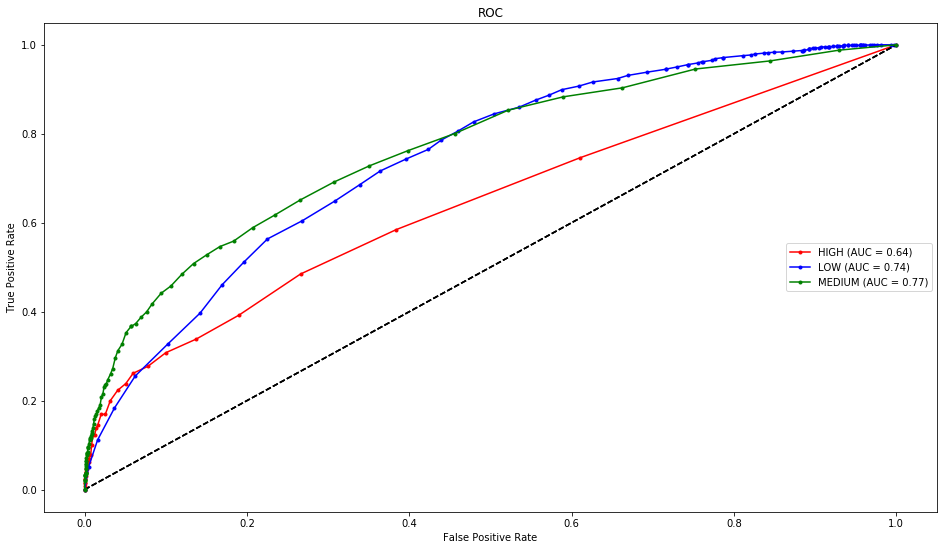

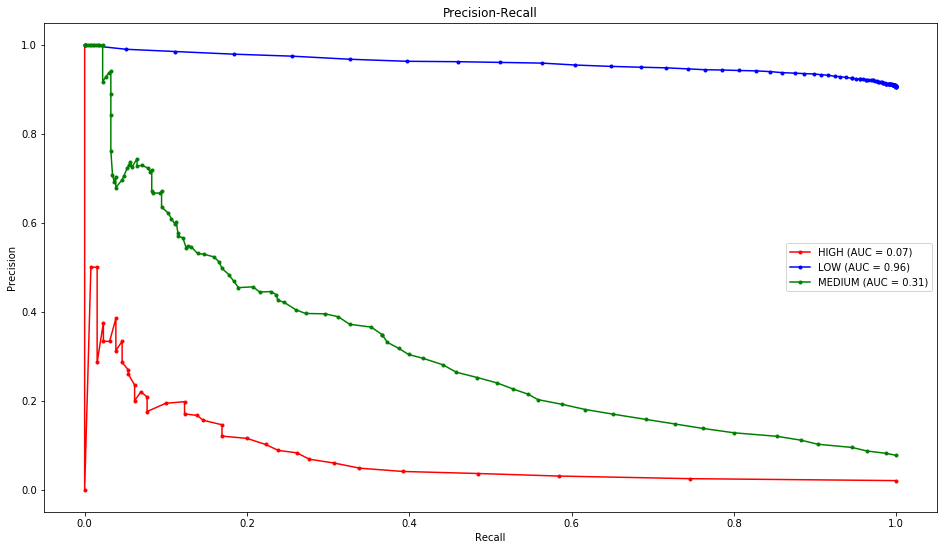

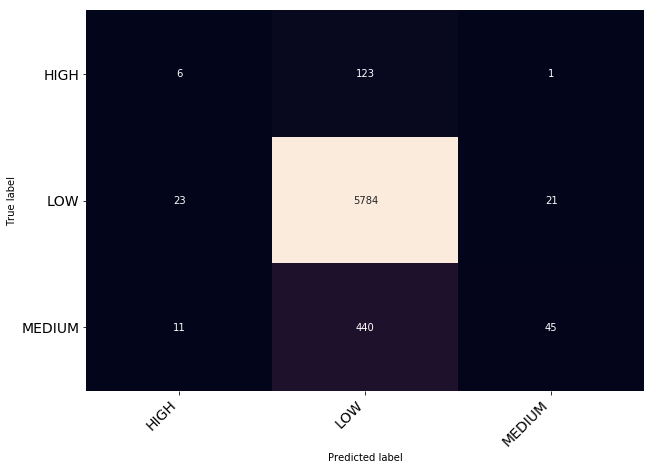

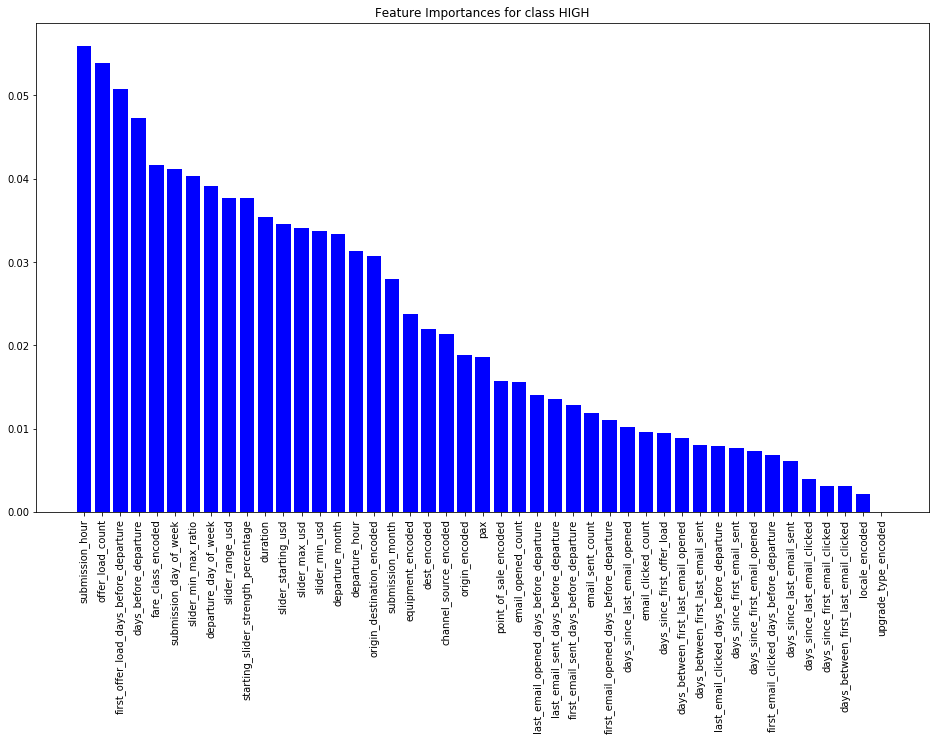

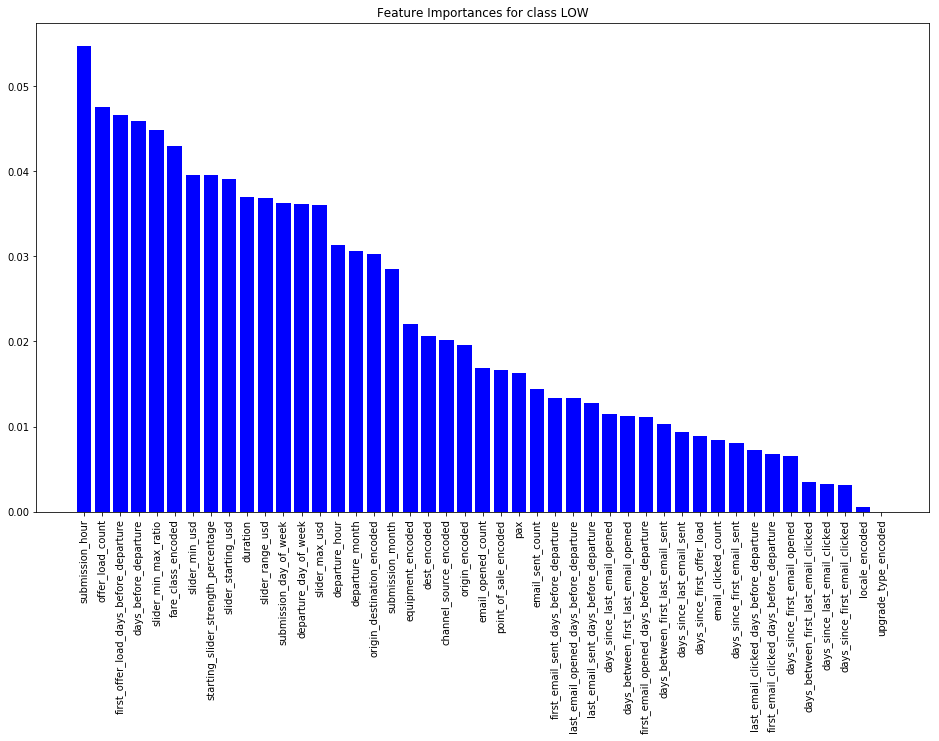

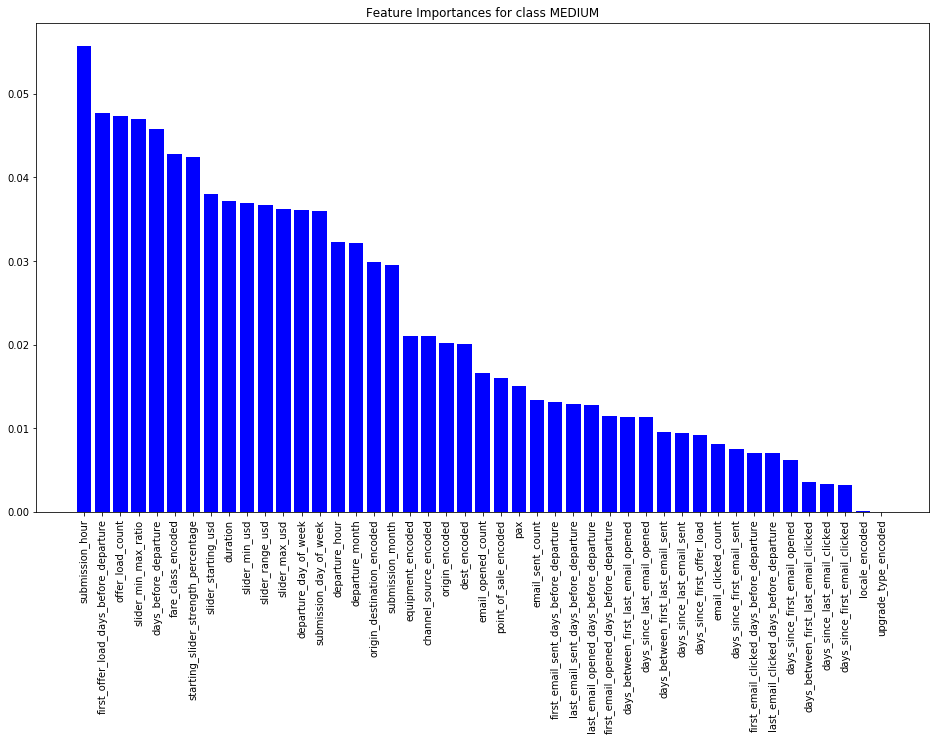

In [21]:
# run with a lot of data
train_and_evaluate(df,plot_learning_curves=False)

training on 14585 rows...
training is done!
testing on 6926 rows...
global roc_auc 0.6637510705446124
#### CLASS HIGH ####
precision 0.0
recall 0.0
f1 0.0
support 126
#### CLASS LOW ####
precision 0.9057834468763589
recall 0.9974461292897047
f1 0.9494074749316317
support 6265
#### CLASS MEDIUM ####
precision 0.5
recall 0.003738317757009346
f1 0.007421150278293135
support 535
# WY offer strength prediction. Feature importance for HIGH
offer_load_count,0.05568531250744731
submission_hour,0.05416555849404038
first_offer_load_days_before_departure,0.0492739519398733
days_before_departure,0.04880106513076592
fare_class_encoded,0.042874083039303255
departure_day_of_week,0.04029208059248939
submission_day_of_week,0.037540771759028535
slider_min_max_ratio,0.03595877006321007
duration,0.03535297332959637
slider_range_usd,0.03460287418470578
starting_slider_strength_percentage,0.03364004111721824
slider_max_usd,0.03344421276918358
slider_starting_usd,0.03279123322794583
slider_min_usd,0.03200213

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# WY offer strength prediction. Feature importance for LOW
submission_hour,0.05640372619869402
days_before_departure,0.049961393202894354
offer_load_count,0.04827545564511677
first_offer_load_days_before_departure,0.04789883533394415
fare_class_encoded,0.04510295958832866
slider_min_max_ratio,0.043754717108918706
departure_day_of_week,0.03888608021277152
duration,0.03845979156988321
submission_day_of_week,0.03823837876686089
slider_starting_usd,0.038203686134455
slider_min_usd,0.037534315997904924
starting_slider_strength_percentage,0.036888754047639256
slider_range_usd,0.03533274582152185
slider_max_usd,0.03308070724519457
departure_hour,0.03131397365912346
origin_destination_encoded,0.03043936585091464
departure_month,0.029304904277304762
submission_month,0.02639906043984383
equipment_encoded,0.02216830598814717
channel_source_encoded,0.02056490736485676
dest_encoded,0.01962009280433858
origin_encoded,0.019616456691344607
email_opened_count,0.018404419645487547
pax,0.0175652249881474

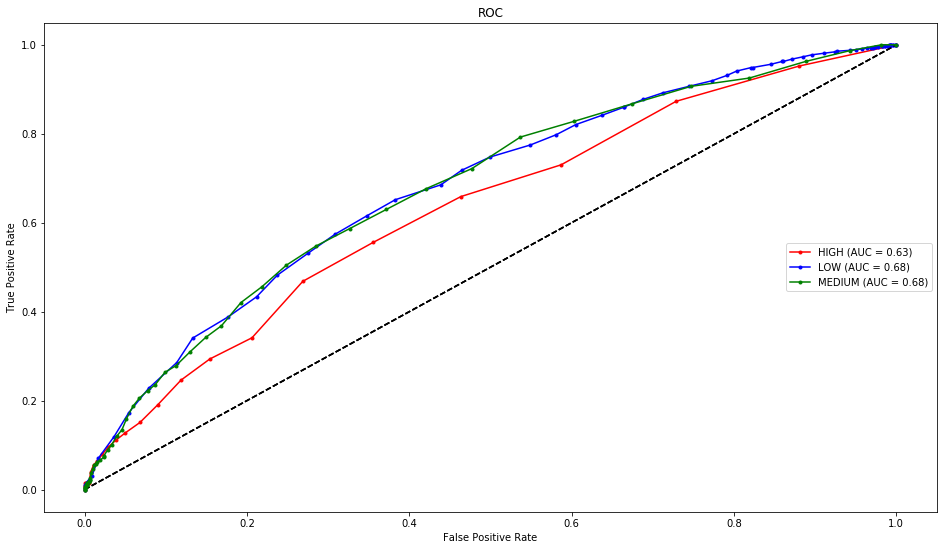

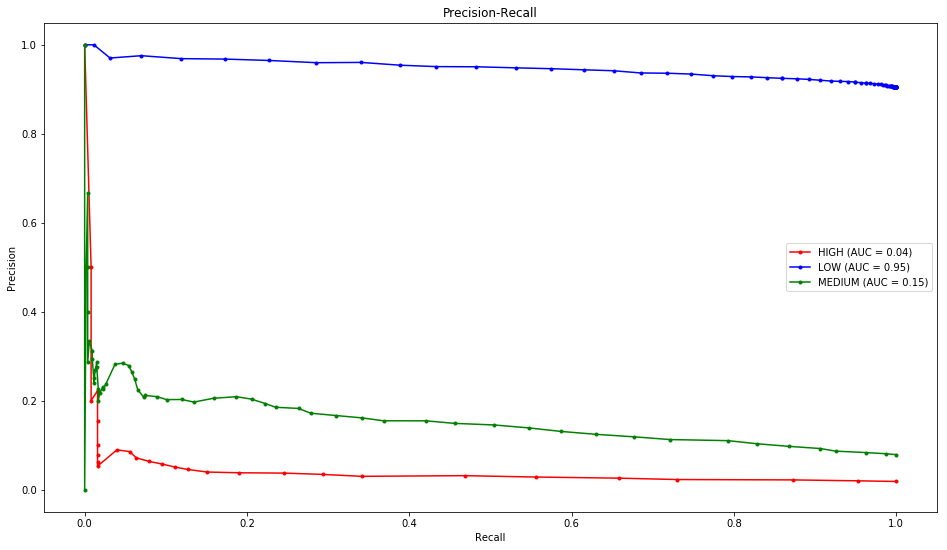

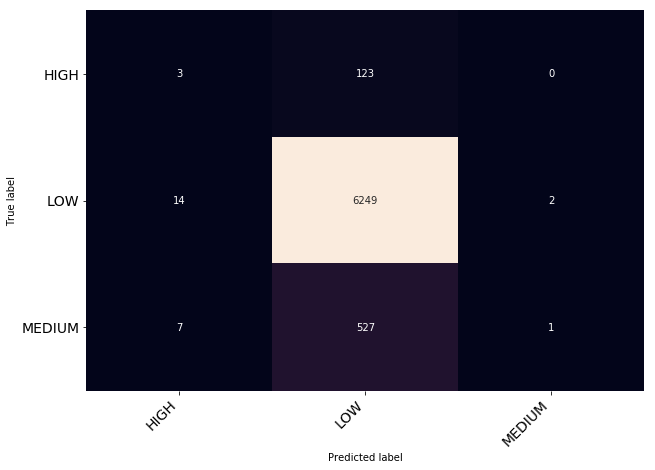

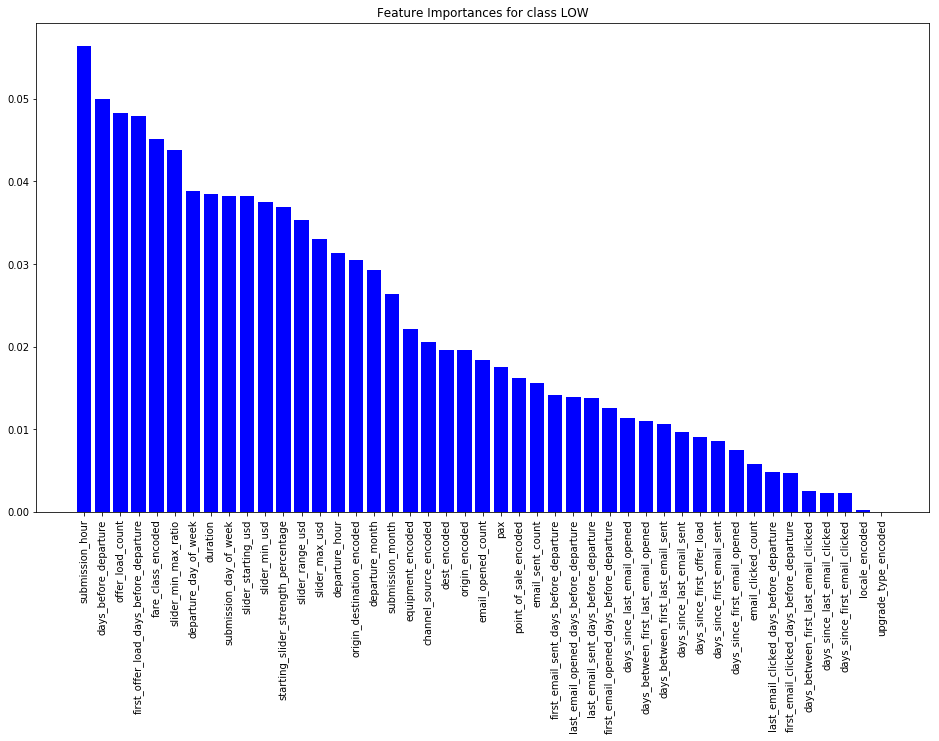

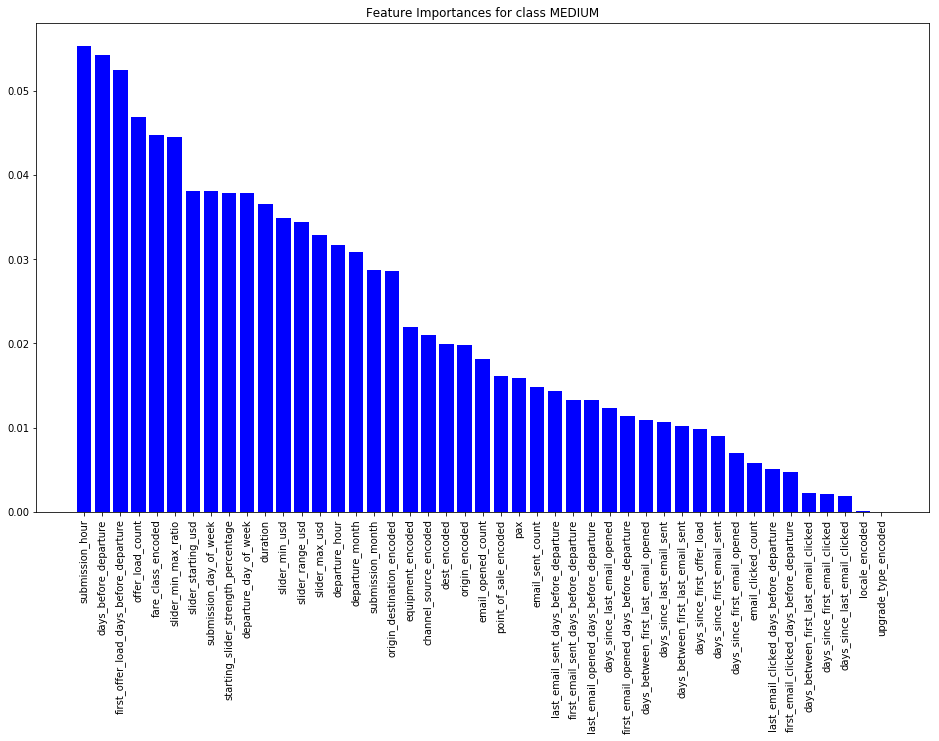

In [23]:
# run with a lot of data split on time (year 2019 vs 2020)
train_and_evaluate(df,plot_learning_curves=False, split_on_time=True)